In [1]:
import medmnist
from medmnist import INFO
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from torchvision.models import resnet18
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from scipy.ndimage import zoom

In [2]:
# Define ResNet18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights='DEFAULT')
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [3]:
# Load organAMNIST dataset
data_flag = 'organamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
num_classes = len(info['label'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

test_dataset = DataClass(split='test', download=download, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

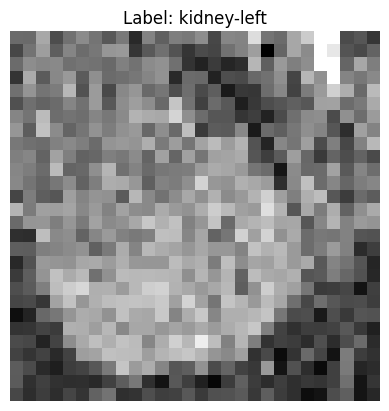

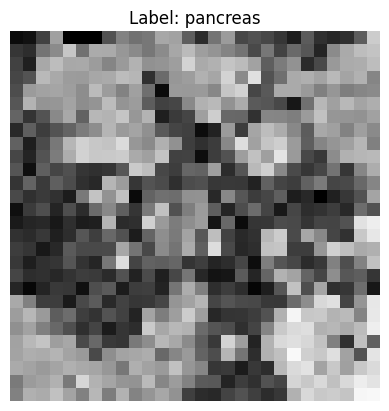

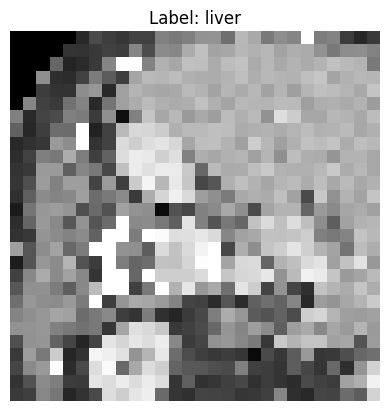

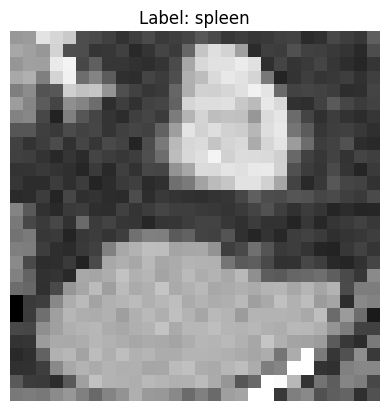

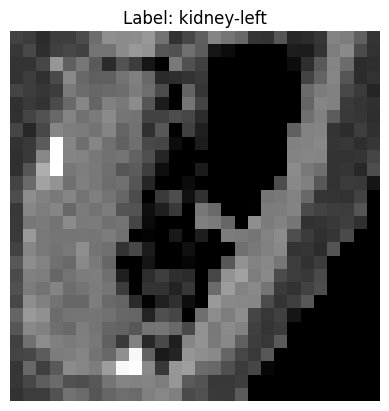

In [4]:
import random
from torchvision.utils import save_image

# Create a directory to save the images
os.makedirs("random_images", exist_ok=True)

# Get 5 random indices
random_indices = random.sample(range(len(test_dataset)), 5)

# Display and save the images
for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]
    plt.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.title(f"Label: {info['label'][str(label.item())]}")
    plt.axis("off")
    plt.show()
    
    # Save the image
    save_image(image, f"random_images/image_{i}_label_{label}.png")

In [5]:
# Load saved models
models = []
for i in range(5):
    model = ResNet18(num_classes=num_classes)
    model.load_state_dict(torch.load(f'resnet18_organamnist{i}.pt'))
    model = model.to(device)
    model.eval()
    models.append(model)

In [6]:
# Define a function to register hooks and capture outputs
def register_hooks(model, layers):
    outputs = {}

    def hook_fn(module, input, output):
        outputs[module] = output

    hooks = []
    for layer in layers:
        hooks.append(layer.register_forward_hook(hook_fn))
    return outputs, hooks

# Define the layers to capture
layers_to_capture = [
    model.model.layer1,
    model.model.layer2,
    model.model.layer3,
    model.model.layer4
]

# Register hooks
layer_outputs, hooks = register_hooks(model, layers_to_capture)


In [ ]:
# Select a sample image from the test dataset
sample_image, _ = test_dataset[random_indices[0]]  # Use the random index 'i' defined earlier
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

# Pass the sample image through the model
_ = model(sample_image)

# Remove hooks
for hook in hooks:
    hook.remove()

# Define a target size (e.g., the size of the largest output or a predefined size)
target_size = (28, 28)  # Example target size

# Combine outputs from all layers
combined_outputs = []
num_frames = None

for layer, output in layer_outputs.items():
    output = output.squeeze(0).cpu().detach().numpy()  # Remove batch dimension and convert to numpy
    if num_frames is None:
        num_frames = output.shape[0]

    # Resize each frame in the output to the target size
    resized_output = np.array([
        zoom(frame, (target_size[0] / frame.shape[0], target_size[1] / frame.shape[1]))
        for frame in output
    ])
    combined_outputs.append(resized_output)

# Stack outputs horizontally for each frame
frames = [np.hstack([layer_output[frame] for layer_output in combined_outputs]) for frame in range(num_frames)]

# Add blank space between layers
frames = [np.hstack([np.hstack([layer_output[frame] for layer_output in combined_outputs]), 
                     np.zeros((combined_outputs[0][frame].shape[0], 10))]) for frame in range(num_frames)]

# Create a figure for the combined animation
fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.imshow(frames[frame], cmap='Greys', vmin=np.min(frames), vmax=np.max(frames))
    ax.set_title(f'Frame {frame + 1}/{num_frames}')
    ax.axis('off')

ani = FuncAnimation(fig, update, frames=num_frames, interval=200)

# Save the combined animation as a GIF
ani.save('combined_layers_output_resized.gif', writer='imagemagick')

plt.close(fig)

In [31]:
# Combine outputs from all images

for lay in range(4):
    combined_outputs = []
    num_frames = None
    for i in range(5):
        # Register hooks
        layer_outputs, hooks = register_hooks(model, layers_to_capture)
        
        combined_frames = []
        sample_image, _ = test_dataset[random_indices[i]]  # Use the random index 'i' defined earlier
        sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

        # Pass the sample image through the model
        _ = model(sample_image)

        # Remove hooks
        for hook in hooks:
            hook.remove()

        # Define a target size (e.g., the size of the largest output or a predefined size)
        target_size = (14, 14)  # Example target size

        for output in layer_outputs[list(layer_outputs)[lay]]:
            output = output.squeeze(0).cpu().detach().numpy()  # Remove batch dimension and convert to numpy
            if num_frames is None:
                num_frames = 10 #output.shape[0]

            # Resize each frame in the output to the target size
            resized_output = np.array([
                zoom(frame, (target_size[0] / frame.shape[0], target_size[1] / frame.shape[1]))
                for frame in output
            ])
            combined_frames.append(resized_output)

        # Stack outputs horizontally for each frame
        frames = [np.vstack([np.vstack([combined_frames[0][frame], np.full((combined_frames[0][frame].shape[0], combined_frames[0][frame].shape[0]), -0.46953085064888)]) for frame in range(num_frames)])]

        combined_outputs.append(frames)

    # Create a figure for the combined animation
    fig, ax = plt.subplots(figsize=(10, 50))

    def update(image):
        ax.clear()
        ax.imshow(combined_outputs[image][0], cmap='Greys', vmin=-0.46953085064888, vmax=np.max(combined_outputs[image]))
        ax.axis('off')

    ani = FuncAnimation(fig, update, frames=5, interval=200)

    # Save the combined animation as a GIF
    ani.save('layer' + str(lay) + '_output_resized.gif', writer='imagemagick')

    plt.close(fig)
    break

In [68]:
# Combine outputs from all images
combined_outputs = []
num_frames = None
for i in range(5):
    
    combined_frames = []
    combined_lay = []
    sample_image, _ = test_dataset[random_indices[i]]  # Use the random index 'i' defined earlier
    sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

    # Define a target size (e.g., the size of the largest output or a predefined size)
    target_size = (14, 14)  # Example target size
    for lay in range(4):
        # Register hooks
        layer_outputs, hooks = register_hooks(model, layers_to_capture)

        # Pass the sample image through the model
        _ = model(sample_image)

        for output in layer_outputs[list(layer_outputs)[lay]]:
            output = output.squeeze(0).cpu().detach().numpy()
            combined_outputs.append(output)
    break

In [74]:
combined_outputs[3].shape

(512, 1, 1)

In [76]:
# Combine outputs from all images
combined_outputs = []
num_frames = None
for i in range(5):
    
    combined_lay = []
    sample_image, _ = test_dataset[random_indices[i]]  # Use the random index 'i' defined earlier
    sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

    # Define a target size (e.g., the size of the largest output or a predefined size)
    target_size = (14, 14)  # Example target size
    for lay in range(4):
        combined_frames = []
        # Register hooks
        layer_outputs, hooks = register_hooks(model, layers_to_capture)

        # Pass the sample image through the model
        _ = model(sample_image)

        for output in layer_outputs[list(layer_outputs)[lay]]:
            output = output.squeeze(0).cpu().detach().numpy()  # Remove batch dimension and convert to numpy
            if num_frames is None:
                num_frames = 10 #output.shape[0]

            # Resize each frame in the output to the target size
            resized_output = np.array([
                zoom(frame, (target_size[0] / frame.shape[0], target_size[1] / frame.shape[1]))
                for frame in output
            ])
            combined_frames.append(resized_output)

        # Stack outputs horizontally for each frame
        frames = np.vstack([np.vstack([combined_frames[0][frame], np.full((combined_frames[0][frame].shape[0], combined_frames[0][frame].shape[0]), -0.46953085064888)]) for frame in range(num_frames)])
        combined_lay.append(frames)
    final_lay = np.hstack([np.hstack([combined_lay[layer], np.full((combined_lay[layer].shape[0], combined_lay[layer].shape[1]), -0.46953085064888)]) for layer in range(4)])
    

    combined_outputs.append(final_lay)

# Create a figure for the combined animation
fig, ax = plt.subplots(figsize=(50, 50))

def update(image):
    ax.clear()
    ax.imshow(combined_outputs[image], cmap='Greys', vmin=-0.46953085064888, vmax=np.max(combined_outputs[image]))
    ax.axis('off')

ani = FuncAnimation(fig, update, frames=5, interval=200)

# Save the combined animation as a GIF
ani.save('layer_output_resized_comb_layers.gif', writer='imagemagick')

plt.close(fig)